<h1 align="center">Exploring Shapley Values of Bank Customer Churn</h1>

After exploring 5 different machine learning logistic regression models in  notebook *1.0-initial-data-exploration.ipynb* our we have decided to go for the a LinearRegression model, with varying alphas (C) which is the model that we will be using to investigate the shapley values. 

# Step 0: Setup

Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

Importing the dataset

In [2]:
df = pd.read_csv("../data/raw/Bank Customer Churn Prediction.csv")

df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Step 1: Pre-Processing 

Splitting the target from the dataset.

In [3]:
X = df.iloc[:,1:-1]
Y = df.iloc[:,-1]

Splitting the model into training, validation and test sets, even though in this case  the training is the most important part. 

Reminder this dataset is unbalanced which is why we will be stratifying Y.

In [4]:
from sklearn.model_selection import train_test_split

xtrain, xval, ytrain, yval = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)
xtrain, xtest, ytrain, ytest = train_test_split(xtrain, ytrain, test_size=0.1/(1-0.1), random_state=42, stratify=ytrain)


Separating numerical variables and categorical variables for pre-processing.

There is no need to process the target Y because the column is already in columns of ones and zeroes. 

In [5]:
#Separating Numerical variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_X = X.select_dtypes(include=numerics)
numeric_cols = list(numeric_X.columns)

#Separating Categorical Variables
features = X.columns 
categorical_cols = list(set(features) - set(numeric_cols)) 


Standarizing Numerical Features

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

xtrain_scl1 = scaler.fit_transform(xtrain[numeric_cols])
xval_scl1 = scaler.transform(xval[numeric_cols])
xtest_scl1 = scaler.transform(xtest[numeric_cols])

One Hot Encoding categorical features

In [7]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

xtrain_scl2 = encoder.fit_transform(xtrain[categorical_cols])
xval_scl2 = encoder.transform(xval[categorical_cols])
xtest_scl2 = encoder.transform(xtest[categorical_cols])

In [8]:
print(numeric_cols)
print(len(numeric_cols))

xtrain_scl1[:1]

['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']
8


array([[ 1.5608137 ,  0.1907517 , -0.35085652,  0.2246468 ,  0.81347659,
        -1.5612409 ,  0.96740189,  1.2190865 ]])

In [9]:
print(categorical_cols)
print(len(categorical_cols))

xtrain_scl2[:1]

['gender', 'country']
2


<1x5 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

Merging transformed features into one.

In [10]:
xtrain_scl = np.hstack([xtrain_scl1, xtrain_scl2.todense()])
xval_scl = np.hstack([xval_scl1, xval_scl2.todense()])
xtest_scl = np.hstack([xtest_scl1, xtest_scl2.todense()])

xtrain_scl[:1]

matrix([[ 1.5608137 ,  0.1907517 , -0.35085652,  0.2246468 ,  0.81347659,
         -1.5612409 ,  0.96740189,  1.2190865 ,  1.        ,  0.        ,
          0.        ,  1.        ,  0.        ]])

# Step 2 : Training the model

A said before the model is going to be a standard LogisticRegression. 

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures 

#Making the inputs more complex by using Polynomial Transformation
# poly = PolynomialFeatures(degree=3, include_bias=True)
# x_poly = poly.fit_transform(np.asarray(xtrain_scl))

poly_reg_model = LogisticRegression( class_weight={0:1, 1:4}, C=1, max_iter=1000)
poly_reg_model.fit(np.asarray(xtrain_scl), ytrain)

LogisticRegression(C=1, class_weight={0: 1, 1: 4}, max_iter=1000)

# Step 3 : Calculating Model Metrics

In [12]:
from sklearn.metrics import classification_report

#getting prediction for validation set
ypred = poly_reg_model.predict(np.asarray(xval_scl))

print(classification_report(y_true=yval, y_pred=ypred))


              precision    recall  f1-score   support

           0       0.90      0.70      0.79       796
           1       0.37      0.69      0.48       204

    accuracy                           0.70      1000
   macro avg       0.63      0.69      0.63      1000
weighted avg       0.79      0.70      0.72      1000



# Step 4: Exploring Shapley values

Shapley values are useful to see the impact of each feature, and to break down how a prediction is made. We will be using the `shap` library to implement this. 

The library is already included in the project requirements, however if you don't have it please add it to your environment by running the following command in your terminal: 

`! pip install shap`

Importing shap, building an explainer and calculating shap values. 


In [13]:
#importing the required package
import shap

#Creating TreeExplainer
explainer = shap.LinearExplainer(poly_reg_model, np.asarray(xtest_scl))

#Calculate Shap values by running it on the test data set

shap_values = explainer.shap_values(np.asarray(xtest_scl))

shap_values.shape, xtest_scl.shape



c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


((1001, 13), (1001, 13))

In [14]:
shap.initjs()

It is important to note this datasets have been concatenated after being transformed. The shap plots will output the features with names such as: Feature 0, Feature 1, Feature 2... but they preserve the order from the original input. Hence we can simply map them here: 

<ul>
    <li>Feature 0: "Credit Score"</li>
    <li>Feature 1: "Age"</li>
    <li>Feature 2: "Tenure"</li>
    <li>Feature 3: "Balance"</li>
    <li>Feature 4: "products_number"</li>
    <li>Feature 5: "credit_card"</li>
    <li>Feature 6: "active_member"</li>
    <li>Feature 7: "estimated_salary"</li>
    <li>Feature 8: "Credit Card"</li>
    <li>Feature 9: "Gender (M)" </li>
    <li>Feature 10: "Gender (F)" </li>
    <li>Feature 11+ Encoded Countries


</ul>

Visualizing explanation for a specific point in the dataset.

In [30]:
shap.force_plot(explainer.expected_value, shap_values[0], (np.asarray(xtest_scl[0])))


Visualizing explanation for all points in my dataset.

In [31]:
shap.force_plot(explainer.expected_value, shap_values[:], (np.asarray(xtest_scl[:])))


Above we can explore each feature individually using the dropdown menu above the graph. For example, we have selected sample order by output value. However, we can also see  how it impacts on all points individually.

Visualizing a summary plot for each class on the whole dataset.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


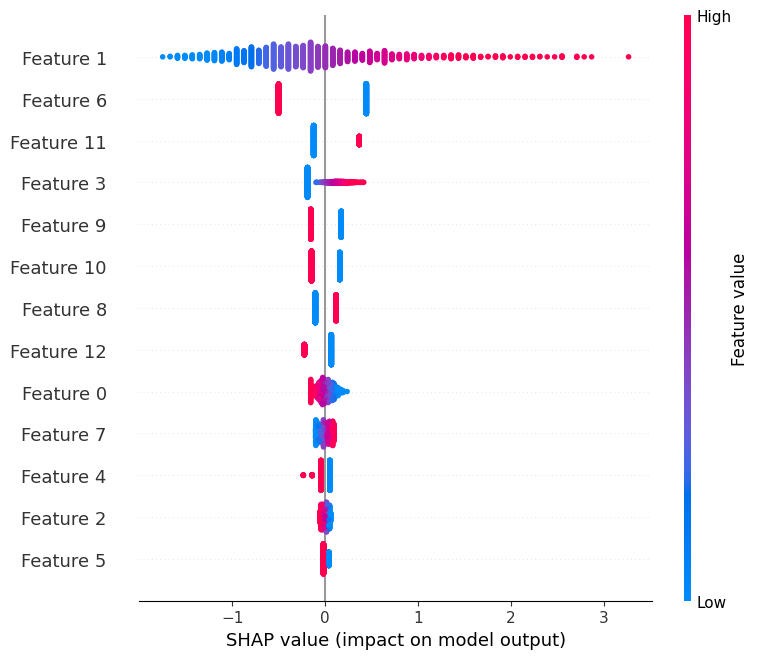

In [28]:
shap.summary_plot(shap_values, np.asarray(xtest_scl))

We can see that Feature 1: Age is the most important factor in a customer's churn rate. Later we have Feature 6: "active_member", and surprisingly enough Feature 11: Countries (encoded) is the third most powerful influencer, hence indicating country culture, or bank competition in a particular country can make a difference.